# MTABT Preprocessing Step
I will replace values that are 2 standard deviations away from the norms with null values and fill in using FBProphet.

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import holidays

# For SARIMAX
from tqdm import tqdm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# For FBProphet
from fbprophet import Prophet

# For LightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna

In [2]:
holidays_2010_2020 = []
for year in range(2010,2022):
    for date in holidays.UnitedStates(years=year).items():
        holidays_2010_2020.append(date[0])
        

        
crossing_rates = {('Brooklyn Battery', 'cash'):9.50,
                 ('Brooklyn Battery', 'ezpass'):6.12,
                 ('Cross Bay', 'cash'):4.75,
                 ('Cross Bay', 'ezpass'):2.29,
                 ('Henry Hudson','cash'):7.00,
                 ('Henry Hudson','ezpass'):2.80,
                 ('Marine Parkway','cash'):4.75,
                 ('Marine Parkway','ezpass'):2.29,
                 ('Queens Midtown','cash'):9.50,
                 ('Queens Midtown','ezpass'):6.12,
                 ('Throgs Neck','cash'): 9.50,
                 ('Throgs Neck','ezpass'): 6.12,
                 ('Triboro','cash'): 9.50,
                 ('Triboro','ezpass'):6.12,
                 ('Verrazano','cash'):19.00,
                 ('Verrazano','ezpass'):12.24,
                 ('Whitestone','cash'):9.50,
                 ('Whitestone','ezpass'):6.12}

bridges_joined = []
for i,x in crossing_rates.keys():
    bridges_joined.append(i + ' ' + x)

### Mean Percentage error
After I have fit with FBProphet, I calculate the mean percentage errors of the values that were not missing(2 std away). 
I will then multiply the predicted amounts by its error weight (1 + mean_percentage_error)

In [6]:
def mean_percentage_error(actual, yhat):
    """
    actual, yhat: list or numpy array
    length of listlike arrays must be same
    
    returns the mean percentage error
    """
    # converting list to array
    if type(actual) == 'list':
        actual = np.array(actual)
    if type(yhat) == 'list':
        yhat = np.array(yhat)
        
        
    _mean = (actual - yhat)/actual
    
    return _mean.sum()/len(_mean)
    

In [7]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    df = df.loc[~df.duplicated()]
    
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro',
        'Triboro',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df.rename(columns={'# Vehicles - E-ZPass': 'ezpass', '# Vehicles - VToll': 'cash', 'Date_Hour': 'datetime'}, inplace=True)
    
    df.drop(columns=['Plaza ID', 'Direction'], inplace=True)
    
    
    _df = df.melt(id_vars=['datetime','plaza_id'], value_vars=['ezpass', 'cash'])
    _df.set_index('datetime', inplace=True)
    _df = _df.groupby(['plaza_id', 'variable'])['value'].resample('1D').sum()
    
    
    return _df

In [8]:
df = return_series('mta.csv')

### Unstacking dataframe to impute values that are 2 standard deviations away to be np.nan.

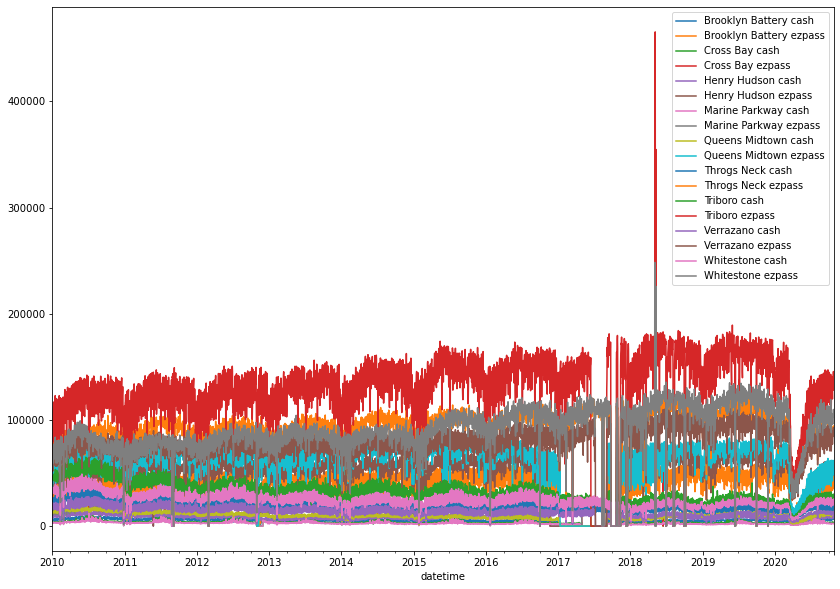

In [21]:
_df = df.unstack().T
_df.columns = [' '.join(column).strip() for column in _df.columns.values]
fig, ax = plt.subplots(figsize=(14,10))
_df.plot(ax = ax)

In [22]:
del df

### Feature Engineering: datetime extraction
In addition to datetime extraction, I will add holidays, post-covid phases and post cashless toll installation phases.

In [32]:
def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter
    _df['dayofyear'] = _df.index.dayofyear

    # NYC lockdown phases
    conditions = [
        (_df.index >= '2020-03-12') & (_df.index < '2020-03-22'),
        (_df.index >= '2020-03-22') & (_df.index < '2020-04-16'),
        (_df.index >= '2020-04-16') & (_df.index < '2020-05-15'),
        (_df.index >= '2020-05-15') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
    ]

    _df['Phase'] = np.select(conditions, choices, -1)
    
    # On 2018, MTA announces their completion of cashless tolls
    _df['Cashless'] = np.where(_df.index >= '2018-01-01', 1, 0)
    
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2010_2020), 1, 0)
    return _df



In [24]:
_df = date_features(_df)

### Feature Engineering: Average Temperature
Adding average temperature calculated by FBProphet. <br>


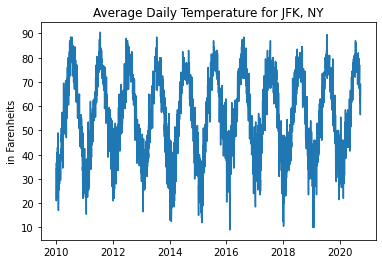

In [18]:
temperature = pd.read_csv('weather.csv', sep ='\t', engine ='python')
temperature['datetime'] = pd.to_datetime(temperature['datetime'])
plt.plot(temperature['datetime'], temperature['temp_average'])
plt.title('Average Daily Temperature for JFK, NY');
plt.ylabel('in Farenheits');

In [19]:
_temperature = date_features(temperature.set_index('datetime')[['temp_average']])
_fb_weather = _temperature.reset_index()[['datetime', 'temp_average']]
_fb_weather.columns = ['ds', 'y']
_fb_weather.head()

,ds,y
0,2010-01-01,36.5
1,2010-01-02,25.0
2,2010-01-03,21.0
3,2010-01-04,26.0
4,2010-01-05,26.5


In [20]:
m = Prophet(
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 300,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
m.fit(_fb_weather)

In [25]:
future = m.make_future_dataframe(periods = 365*2)
forecast = m.predict(future)

In [26]:
sliced_forecast = forecast.loc[forecast['ds'].isin(pd.date_range(start='2010-01-01', end='2020-2-29'))]
sliced_forecast.reset_index(drop=True, inplace=True)

In [27]:
sliced_forecast = sliced_forecast[['ds', 'yhat']]
sliced_forecast.columns = ['datetime', 'temp_average']
sliced_forecast.set_index('datetime', inplace=True)
sliced_forecast.head()

,temp_average
datetime,
2010-01-01,36.372828
2010-01-02,35.877365
2010-01-03,35.874707
2010-01-04,35.631358
2010-01-05,36.069875


In [28]:
_df['temp_average'] = sliced_forecast['temp_average']

In [29]:
_df.head()

,Brooklyn Battery cash,Brooklyn Battery ezpass,Cross Bay cash,Cross Bay ezpass,Henry Hudson cash,Henry Hudson ezpass,Marine Parkway cash,Marine Parkway ezpass,Queens Midtown cash,Queens Midtown ezpass,...,year,week,day,quarter,dayofyear,Phase,Cashless,weekend,holiday,temp_average
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01,4902,17043,3577,9760,7491,27175,2899,10243,12295,31460,...,2010,53,1,1,1,-1,0,0,1,36.372828
2010-01-02,5347,20799,3508,11673,9396,37110,3053,11552,14182,40597,...,2010,53,2,1,2,-1,0,1,0,35.877365
2010-01-03,4957,21605,3030,9983,7959,34720,2674,10155,12846,40411,...,2010,53,3,1,3,-1,0,1,0,35.874707
2010-01-04,5759,35557,3494,16032,8653,45846,3341,16503,12441,55307,...,2010,1,4,1,4,-1,0,0,0,35.631358
2010-01-05,6096,38810,3647,16821,8818,49009,3285,17418,12443,59430,...,2010,1,5,1,5,-1,0,0,0,36.069875


---

### Imputing 2 standard deviations with np.nan

In [30]:
_to_replace = _df[:'2020-02'].copy(deep=True)

In [31]:
_to_replace

,Brooklyn Battery cash,Brooklyn Battery ezpass,Cross Bay cash,Cross Bay ezpass,Henry Hudson cash,Henry Hudson ezpass,Marine Parkway cash,Marine Parkway ezpass,Queens Midtown cash,Queens Midtown ezpass,...,year,week,day,quarter,dayofyear,Phase,Cashless,weekend,holiday,temp_average
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01,4902,17043,3577,9760,7491,27175,2899,10243,12295,31460,...,2010,53,1,1,1,-1,0,0,1,36.372828
2010-01-02,5347,20799,3508,11673,9396,37110,3053,11552,14182,40597,...,2010,53,2,1,2,-1,0,1,0,35.877365
2010-01-03,4957,21605,3030,9983,7959,34720,2674,10155,12846,40411,...,2010,53,3,1,3,-1,0,1,0,35.874707
2010-01-04,5759,35557,3494,16032,8653,45846,3341,16503,12441,55307,...,2010,1,4,1,4,-1,0,0,0,35.631358
2010-01-05,6096,38810,3647,16821,8818,49009,3285,17418,12443,59430,...,2010,1,5,1,5,-1,0,0,0,36.069875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-25,5180,52130,2713,20166,5979,62776,1853,19577,9882,71677,...,2020,9,25,1,56,-1,1,0,0,37.694789
2020-02-26,5070,51882,2851,20887,5979,61826,1997,20495,10161,74159,...,2020,9,26,1,57,-1,1,0,0,37.977923
2020-02-27,5551,56336,2859,20936,6451,66178,1751,19326,10880,77537,...,2020,9,27,1,58,-1,1,0,0,37.989528


In [32]:
for i in bridges_joined:
    print(i, 
          _to_replace[i].mean() - _to_replace[i].std() * 2, 
          _to_replace[i].mean() + _to_replace[i].std() * 2)

Brooklyn Battery cash 1064.4675187552316 8972.619226934425
Brooklyn Battery ezpass 9431.270599655913 69255.04513310271
Cross Bay cash 293.7279581169719 6384.422903951994
Cross Bay ezpass 6587.71548581645 27905.75326418355
Henry Hudson cash 1334.0785876519158 13710.892317520498
Henry Hudson ezpass 12834.290998501187 88624.12333339537
Marine Parkway cash 80.91117516288568 5163.887855009529
Marine Parkway ezpass 6543.046640777544 28691.764242843143
Queens Midtown cash 1681.8596376783744 17238.92861663197
Queens Midtown ezpass 18269.325562113758 106062.75471805866
Throgs Neck cash 7549.813624375727 30516.845858382898
Throgs Neck ezpass 54114.71124818096 131961.71816992247
Triboro cash 9362.213367438908 53436.96174031972
Triboro ezpass 59690.65270054083 203353.64794601087
Verrazano cash 3794.890055666572 22388.070612436877
Verrazano ezpass 40225.15998202289 116069.48603090816
Whitestone cash 9763.738216563777 37710.747774815536
Whitestone ezpass 47200.66783880152 134922.84724740539


In [33]:
for i in bridges_joined:
    conditions = [
        _to_replace[i] < _to_replace[i].mean() - _to_replace[i].std() * 2,
        _to_replace[i] > _to_replace[i].mean() + _to_replace[i].std() * 2
    ]
    choices = [
        np.nan,
        np.nan
    ]
    _to_replace[i] = np.select(conditions, choices, _to_replace[i])

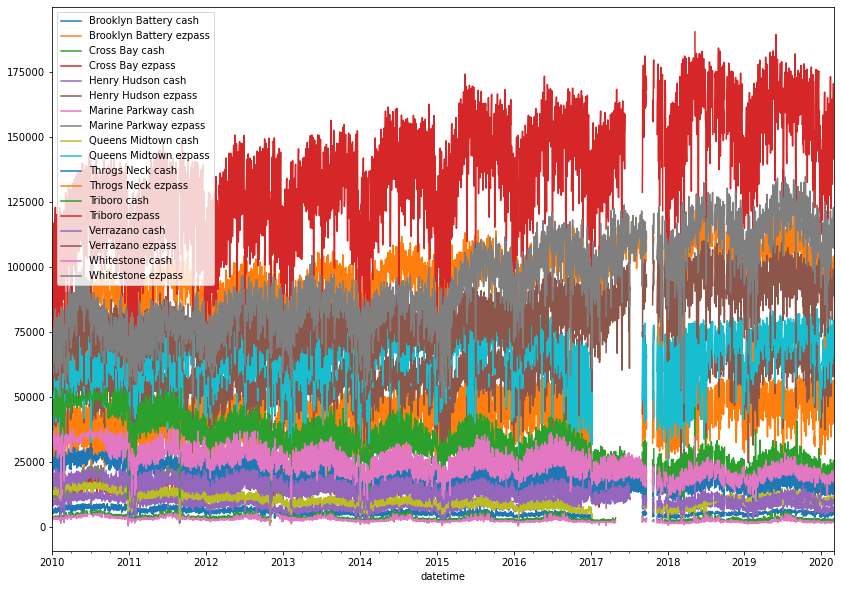

In [34]:
_to_replace[bridges_joined].plot(figsize=(14,10))

In [35]:
_to_replace.isna().sum()

Brooklyn Battery cash      363
Brooklyn Battery ezpass    338
Cross Bay cash             368
Cross Bay ezpass           213
Henry Hudson cash          379
Henry Hudson ezpass        368
Marine Parkway cash        361
Marine Parkway ezpass      227
Queens Midtown cash        355
Queens Midtown ezpass      324
Throgs Neck cash           196
Throgs Neck ezpass         117
Triboro cash               259
Triboro ezpass             172
Verrazano cash             251
Verrazano ezpass           154
Whitestone cash            193
Whitestone ezpass          105
month                        0
dayofweek                    0
year                         0
week                         0
day                          0
quarter                      0
dayofyear                    0
Phase                        0
Cashless                     0
weekend                      0
holiday                      0
temp_average                 0
dtype: int64

In [36]:
_to_replace.isna().sum().sum()

4743

There are 4743 values I need to replace.

---

In [39]:
# _fb_exog will be used for additional independent features
_fb_exog = _to_replace[['month', 'dayofweek', 'quarter', 'year',
           'Phase', 'weekend', 'holiday', 'temp_average', 'Cashless']]

In [40]:
# yhat results will be predicted from _fb_exog_reset
_test_set = _fb_exog.reset_index()
_test_set.rename(columns={'datetime':'ds'}, inplace=True)

In [50]:
def fb_prophet_yhat(bridge):
    """
    returns y_hat values for bridge adjusted based off of mean_percentage_error
    ex: if mean percentage error is -0.01, adjust yhat by multiplying 0.99 (1 + (-0.01))
    
    """
    _training = _to_replace[[bridge]].copy(deep=True)
    _training = _training.join(_fb_exog)
    _training.reset_index(inplace=True)
    _training.rename(columns = {bridge:'y', 'datetime': 'ds'}, inplace=True)
    
    # hyperparameters assisted from: https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
    m = Prophet(
        changepoint_prior_scale= 30,
        holidays_prior_scale = 20,
        seasonality_prior_scale = 35,
        n_changepoints = 300,
        seasonality_mode = 'additive',
        daily_seasonality = False,
        weekly_seasonality=False,
        yearly_seasonality = False
            ).add_seasonality(name = 'monthly', period = 30.5, fourier_order=12
            ).add_seasonality(name = 'weekly', period = 7, fourier_order = 20
            ).add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20
            ).add_seasonality(name = 'quarterly', period = 365.25/4, fourier_order = 5, prior_scale=15)
    for i in _fb_exog.columns:
        m.add_regressor(i)
        
        
    m.fit(_training)
        
    
    forecast = m.predict(_test_set)
    

    _mult = 1 + mean_percentage_error(_training[~_training['y'].isna()]['y'],
                     forecast.loc[forecast['ds'].isin(_training[~_training['y'].isna()]['ds'])]['yhat'])
    
    forecast.set_index('ds', inplace=True)
    
    return forecast['yhat'] * _mult

In [51]:
### Creating results dataframe

In [52]:
_yhat_results = pd.DataFrame()
_yhat_results['ds'] = _to_replace.index
_yhat_results.set_index('ds', inplace=True)

In [53]:
for i in tqdm(bridges_joined):
    _yhat_results[i] = fb_prophet_yhat(i)

100%|██████████| 18/18 [1:12:43<00:00, 242.41s/it]


### Replacing null values:

In [57]:
_to_replace_copy = _to_replace.copy(deep=True)

In [58]:
_to_replace_copy.reset_index(inplace=True)
_to_replace_copy.rename(columns={'datetime':'ds'}, inplace=True)
_to_replace_copy.set_index('ds', inplace=True)

In [61]:
for i in bridges_joined:
    _to_replace_copy[i].fillna(_yhat_results[i], inplace=True)

In [68]:
#concatting dataframe post March 2020
_concat = return_series('mta.csv')

In [70]:
_concat_unstack = _concat.unstack().T
# unstacking multi-index to single for easability
_concat_unstack.columns = [' '.join(column).strip() for column in _concat_unstack.columns.values]


In [73]:
_concat_unstack = _concat_unstack['2020-03':].copy(deep=True)
_concat_unstack.reset_index(inplace=True)
_concat_unstack.rename(columns = {'datetime': 'ds'}, inplace=True)
_concat_unstack.set_index('ds', inplace=True)
_concat_unstack

,Brooklyn Battery cash,Brooklyn Battery ezpass,Cross Bay cash,Cross Bay ezpass,Henry Hudson cash,Henry Hudson ezpass,Marine Parkway cash,Marine Parkway ezpass,Queens Midtown cash,Queens Midtown ezpass,Throgs Neck cash,Throgs Neck ezpass,Triboro cash,Triboro ezpass,Verrazano cash,Verrazano ezpass,Whitestone cash,Whitestone ezpass
ds,,,,,,,,,,,,,,,,,,
2020-03-01,4373,37462,2070,14440,6606,53701,1527,13531,10237,63461,16962,95155,22076,134756,10192,79973,19582,102766
2020-03-02,5276,51256,2761,19899,6331,62316,1887,19261,10385,71096,13086,94732,21739,151823,9142,91803,17998,113977
2020-03-03,5315,53495,2803,20373,6155,63889,1851,20370,10369,71948,12445,95345,21727,154621,8542,93210,17323,111666
2020-03-04,5488,53585,2950,20866,6486,65572,2036,20770,10557,73724,12840,99001,22556,159497,8825,95187,18087,114377
2020-03-05,5521,54494,2856,21032,6804,66928,2003,20506,10871,75097,13671,102022,23911,168128,9085,96822,18436,115873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-27,7017,48686,3119,18489,7327,49382,2504,18027,10890,54152,14575,83780,25680,132213,10768,83895,19322,96509
2020-10-28,7169,49697,2964,18280,7682,53050,2203,17072,11612,57293,14343,83983,26030,135054,10720,84472,19636,97112
2020-10-29,6817,48263,2902,17012,7623,52082,2198,16172,11002,56973,13741,78270,24863,129996,10724,82194,19328,95198


In [78]:
_concat_unstack = date_features(_concat_unstack)

In [79]:
_to_tableau = pd.concat([_to_replace_copy, _concat_unstack])

In [82]:
_to_tableau.drop(columns='temp_average', inplace=True)

In [83]:
_to_tableau

,Brooklyn Battery cash,Brooklyn Battery ezpass,Cross Bay cash,Cross Bay ezpass,Henry Hudson cash,Henry Hudson ezpass,Marine Parkway cash,Marine Parkway ezpass,Queens Midtown cash,Queens Midtown ezpass,...,dayofweek,year,week,day,quarter,dayofyear,Phase,Cashless,weekend,holiday
ds,,,,,,,,,,,,,,,,,,,,,
2010-01-01,4902.0,17043.0,3577.0,9760.0,7491.0,27175.0,2899.0,10243.0,12295.0,31460.0,...,4,2010,53,1,1,1,-1,0,0,1
2010-01-02,5347.0,20799.0,3508.0,11673.0,9396.0,37110.0,3053.0,11552.0,14182.0,40597.0,...,5,2010,53,2,1,2,-1,0,1,0
2010-01-03,4957.0,21605.0,3030.0,9983.0,7959.0,34720.0,2674.0,10155.0,12846.0,40411.0,...,6,2010,53,3,1,3,-1,0,1,0
2010-01-04,5759.0,35557.0,3494.0,16032.0,8653.0,45846.0,3341.0,16503.0,12441.0,55307.0,...,0,2010,1,4,1,4,-1,0,0,0
2010-01-05,6096.0,38810.0,3647.0,16821.0,8818.0,49009.0,3285.0,17418.0,12443.0,59430.0,...,1,2010,1,5,1,5,-1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-27,7017.0,48686.0,3119.0,18489.0,7327.0,49382.0,2504.0,18027.0,10890.0,54152.0,...,1,2020,44,27,4,301,7,1,0,0
2020-10-28,7169.0,49697.0,2964.0,18280.0,7682.0,53050.0,2203.0,17072.0,11612.0,57293.0,...,2,2020,44,28,4,302,7,1,0,0
2020-10-29,6817.0,48263.0,2902.0,17012.0,7623.0,52082.0,2198.0,16172.0,11002.0,56973.0,...,3,2020,44,29,4,303,7,1,0,0


In [92]:
_to_tableau_final = pd.DataFrame(columns=crossing_rates.keys())

In [93]:
for left, right in zip(_to_tableau_final.columns, bridges_joined):
    _to_tableau_final[left] = _to_tableau[right]

In [96]:
_to_tableau_final.reset_index(inplace=True)

In [101]:
_to_tableau_final = pd.melt(_to_tableau_final, id_vars = ['ds'])
_to_tableau_final.columns = ['datetime', 'crossing', 'variation', 'count']

In [103]:
_to_tableau_final.set_index('datetime', inplace=True)

In [104]:
_to_tableau_final = date_features(_to_tableau_final)

In [106]:
_to_tableau_final.to_csv('to_tableau.csv', index=True, header=True)

In [3]:
df = pd.read_csv('to_tableau.csv')

In [4]:
df

,datetime,crossing,variation,count,month,dayofweek,year,week,day,quarter,dayofyear,Phase,Cashless,weekend,holiday
0,2010-01-01,Brooklyn Battery,cash,4902.0,1,4,2010,53,1,1,1,-1,0,0,1
1,2010-01-02,Brooklyn Battery,cash,5347.0,1,5,2010,53,2,1,2,-1,0,1,0
2,2010-01-03,Brooklyn Battery,cash,4957.0,1,6,2010,53,3,1,3,-1,0,1,0
3,2010-01-04,Brooklyn Battery,cash,5759.0,1,0,2010,1,4,1,4,-1,0,0,0
4,2010-01-05,Brooklyn Battery,cash,6096.0,1,1,2010,1,5,1,5,-1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71221,2020-10-27,Whitestone,ezpass,96509.0,10,1,2020,44,27,4,301,7,1,0,0
71222,2020-10-28,Whitestone,ezpass,97112.0,10,2,2020,44,28,4,302,7,1,0,0
71223,2020-10-29,Whitestone,ezpass,95198.0,10,3,2020,44,29,4,303,7,1,0,0
71224,2020-10-30,Whitestone,ezpass,100435.0,10,4,2020,44,30,4,304,7,1,0,0


In [8]:
_ender = return_series('mta.csv')

In [21]:
_bob = _ender.unstack().T

In [22]:
_bob = _bob['2020-11-1':]

In [26]:
_bob.reset_index(inplace=True)

In [28]:
_bob = pd.melt(_bob,id_vars=['datetime'])

In [30]:
_bob.columns = ['datetime', 'crossing', 'variation', 'count']
_bob

,datetime,crossing,variation,count
0,2020-11-01,Brooklyn Battery,cash,4833
1,2020-11-02,Brooklyn Battery,cash,6538
2,2020-11-03,Brooklyn Battery,cash,5875
3,2020-11-04,Brooklyn Battery,cash,6279
4,2020-11-05,Brooklyn Battery,cash,7227
...,...,...,...,...
121,2020-11-03,Whitestone,ezpass,89018
122,2020-11-04,Whitestone,ezpass,94310
123,2020-11-05,Whitestone,ezpass,100195
124,2020-11-06,Whitestone,ezpass,107605


In [31]:
_bob.set_index('datetime', inplace=True)


NameError: name 'date_features' is not defined

In [33]:
_bob = date_features(_bob)

In [35]:
_bob.reset_index(inplace=True)

In [36]:
_bob

,datetime,crossing,variation,count,month,dayofweek,year,week,day,quarter,dayofyear,Phase,Cashless,weekend,holiday
0,2020-11-01,Brooklyn Battery,cash,4833,11,6,2020,44,1,4,306,7,1,1,0
1,2020-11-02,Brooklyn Battery,cash,6538,11,0,2020,45,2,4,307,7,1,0,0
2,2020-11-03,Brooklyn Battery,cash,5875,11,1,2020,45,3,4,308,7,1,0,0
3,2020-11-04,Brooklyn Battery,cash,6279,11,2,2020,45,4,4,309,7,1,0,0
4,2020-11-05,Brooklyn Battery,cash,7227,11,3,2020,45,5,4,310,7,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2020-11-03,Whitestone,ezpass,89018,11,1,2020,45,3,4,308,7,1,0,0
122,2020-11-04,Whitestone,ezpass,94310,11,2,2020,45,4,4,309,7,1,0,0
123,2020-11-05,Whitestone,ezpass,100195,11,3,2020,45,5,4,310,7,1,0,0
124,2020-11-06,Whitestone,ezpass,107605,11,4,2020,45,6,4,311,7,1,0,0


In [39]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [42]:
_final = pd.concat([df,_bob])
_final

,datetime,crossing,variation,count,month,dayofweek,year,week,day,quarter,dayofyear,Phase,Cashless,weekend,holiday
0,2010-01-01,Brooklyn Battery,cash,4902.0,1,4,2010,53,1,1,1,-1,0,0,1
1,2010-01-02,Brooklyn Battery,cash,5347.0,1,5,2010,53,2,1,2,-1,0,1,0
2,2010-01-03,Brooklyn Battery,cash,4957.0,1,6,2010,53,3,1,3,-1,0,1,0
3,2010-01-04,Brooklyn Battery,cash,5759.0,1,0,2010,1,4,1,4,-1,0,0,0
4,2010-01-05,Brooklyn Battery,cash,6096.0,1,1,2010,1,5,1,5,-1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2020-11-03,Whitestone,ezpass,89018.0,11,1,2020,45,3,4,308,7,1,0,0
122,2020-11-04,Whitestone,ezpass,94310.0,11,2,2020,45,4,4,309,7,1,0,0
123,2020-11-05,Whitestone,ezpass,100195.0,11,3,2020,45,5,4,310,7,1,0,0
124,2020-11-06,Whitestone,ezpass,107605.0,11,4,2020,45,6,4,311,7,1,0,0


In [43]:
_final.to_csv('to_tableau.csv', index=False,header=True)